In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import time
from string import punctuation
import datetime
from keras.layers import Dense,Input,Flatten,concatenate,Dropout,Lambda
from keras.models import Model
import keras.backend as K
import re
from keras.losses import binary_crossentropy
from  keras.callbacks import EarlyStopping,ModelCheckpoint
import codecs
import keras
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from sklearn.metrics import f1_score
from keras import optimizers
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras import optimizers
from keras.layers import Dense,Input,Flatten,concatenate,Dropout,Lambda,BatchNormalization, GaussianNoise
from keras.models import Model
import keras.backend as K
from keras.callbacks import Callback
from  keras.callbacks import EarlyStopping,ModelCheckpoint
import datetime
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
import time

warnings.filterwarnings("ignore")
pd.set_option('max_columns', None)
np.random.seed(0)

Using TensorFlow backend.


## Data description
GameId - a unique game identifier<br/>
PlayId - a unique play identifier<br/>
Team - home or away<br/>
X - player position along the long axis of the field. See figure below.<br/>
Y - player position along the short axis of the field. See figure below.<br/>
S - speed in yards/second<br/>
A - acceleration in yards/second^2<br/>
Dis - distance traveled from prior time point, in yards<br/>
Orientation - orientation of player (deg)<br/>
Dir - angle of player motion (deg)<br/>
NflId - a unique identifier of the player<br/>
DisplayName - player's name<br/>
JerseyNumber - jersey number<br/>
Season - year of the season<br/>
YardLine - the yard line of the line of scrimmage<br/>
Quarter - game quarter (1-5, 5 == overtime)<br/>
GameClock - time on the game clock<br/>
PossessionTeam - team with possession<br/>
Down - the down (1-4)<br/>
Distance - yards needed for a first down<br/>
FieldPosition - which side of the field the play is happening on<br/>
HomeScoreBeforePlay - home team score before play started<br/>
VisitorScoreBeforePlay - visitor team score before play started<br/>
NflIdRusher - the NflId of the rushing player<br/>
OffenseFormation - offense formation<br/>
OffensePersonnel - offensive team positional grouping<br/>
DefendersInTheBox - number of defenders lined up near the line of scrimmage, spanning the width of the offensive line<br/>
DefensePersonnel - defensive team positional grouping<br/>
PlayDirection - direction the play is headed<br/>
TimeHandoff - UTC time of the handoff<br/>
TimeSnap - UTC time of the snap<br/>
<br/>
**Yards - the yardage gained on the play (you are predicting this)**<br/>
<br/>
PlayerHeight - player height (ft-in)<br/>
PlayerWeight - player weight (lbs)<br/>
PlayerBirthDate - birth date (mm/dd/yyyy)<br/>
PlayerCollegeName - where the player attended college<br/>
Position - the player's position (the specific role on the field that they typically play)<br/>
HomeTeamAbbr - home team abbreviation<br/>
VisitorTeamAbbr - visitor team abbreviation<br/>
Week - week into the season<br/>
Stadium - stadium where the game is being played<br/>
Location - city where the game is being player<br/>
StadiumType - description of the stadium environment<br/>
Turf - description of the field surface<br/>
GameWeather - description of the game weather<br/>
Temperature - temperature (deg F)<br/>
Humidity - humidity<br/>
WindSpeed - wind speed in miles/hour<br/>
WindDirection - wind direction<br/>


## 1. Read data and check info

In [2]:
path1 = '/kaggle/input/nfl-big-data-bowl-2020/train.csv'
path2 = '../input/nfl-big-data-bowl-2020/train.csv'
if os.path.exists(path1):
    df = pd.read_csv(path1)
    TRAIN_OFFLINE = False

else:
    df = pd.read_csv(path2)
    TRAIN_OFFLINE = True
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 509762 entries, 0 to 509761
Data columns (total 49 columns):
GameId                    509762 non-null int64
PlayId                    509762 non-null int64
Team                      509762 non-null object
X                         509762 non-null float64
Y                         509762 non-null float64
S                         509762 non-null float64
A                         509762 non-null float64
Dis                       509762 non-null float64
Orientation               509744 non-null float64
Dir                       509748 non-null float64
NflId                     509762 non-null int64
DisplayName               509762 non-null object
JerseyNumber              509762 non-null int64
Season                    509762 non-null int64
YardLine                  509762 non-null int64
Quarter                   509762 non-null int64
GameClock                 509762 non-null object
PossessionTeam            509762 non-null object
Down   

## 1. Visualize Yards (target)

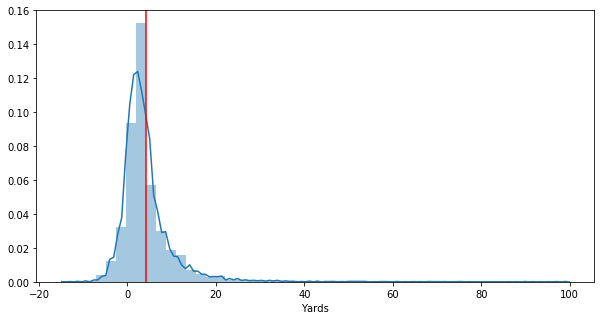

In [3]:
plt.figure(figsize=(10, 5))
sns.distplot(df['Yards'], kde=True)
plt.axvline(df['Yards'].mean(), 0, 1, c='r')

## 3. Data Head

In [4]:
df.head(22)

,GameId,PlayId,Team,X,Y,S,A,Dis,Orientation,Dir,NflId,DisplayName,JerseyNumber,Season,YardLine,Quarter,GameClock,PossessionTeam,Down,Distance,FieldPosition,HomeScoreBeforePlay,VisitorScoreBeforePlay,NflIdRusher,OffenseFormation,OffensePersonnel,DefendersInTheBox,DefensePersonnel,PlayDirection,TimeHandoff,TimeSnap,Yards,PlayerHeight,PlayerWeight,PlayerBirthDate,PlayerCollegeName,Position,HomeTeamAbbr,VisitorTeamAbbr,Week,Stadium,Location,StadiumType,Turf,GameWeather,Temperature,Humidity,WindSpeed,WindDirection
0,2017090700,20170907000118,away,73.91,34.84,1.69,1.13,0.40,81.99,177.18,496723,Eric Berry,29,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-0,212,12/29/1988,Tennessee,SS,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
1,2017090700,20170907000118,away,74.67,32.64,0.42,1.35,0.01,27.61,198.70,2495116,Allen Bailey,97,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-3,288,03/25/1989,Miami,DE,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
2,2017090700,20170907000118,away,74.00,33.20,1.22,0.59,0.31,3.01,202.73,2495493,Justin Houston,50,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-3,270,01/21/1989,Georgia,DE,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
3,2017090700,20170907000118,away,71.46,27.70,0.42,0.54,0.02,359.77,105.64,2506353,Derrick Johnson,56,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-3,245,11/22/1982,Texas,ILB,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
4,2017090700,20170907000118,away,69.32,35.42,1.82,2.43,0.16,12.63,164.31,2530794,Ron Parker,38,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-0,206,08/17/1987,Newberry,FS,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
5,2017090700,20170907000118,away,75.06,24.00,1.01,0.32,0.18,308.34,95.01,2543494,Dee Ford,55,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-2,252,03/19/1991,Auburn,DE,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
6,2017090700,20170907000118,away,74.11,16.64,1.11,0.83,0.02,357.23,322.59,2543637,Terrance Mitchell,39,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,5-11,190,05/17/1992,Oregon,CB,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
7,2017090700,20170907000118,away,73.37,18.73,1.24,0.74,0.13,328.52,270.04,2543851,Phillip Gaines,23,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-0,193,04/04/1991,Rice,CB,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
8,2017090700,20170907000118,away,56.63,26.90,0.26,1.86,0.28,344.70,55.31,2550257,Daniel Sorensen,49,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-2,208,03/05/1990,Brigham Young,SS,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
9,2017090700,20170907000118,away,73.35,38.83,4.55,0.76,0.51,75.47,190.84,2552488,Marcus Peters,22,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB

In [5]:
def process_unique_features(df, fillna=-999):
    
    def clean_weather(txt):
        ans = 1
        if pd.isna(txt):
            return 0
        if 'partly' in txt:
            ans*=0.5
        if 'climate controlled' in txt or 'indoor' in txt:
            return ans*3
        if 'sunny' in txt or 'sun' in txt:
            return ans*2
        if 'clear' in txt:
            return ans
        if 'cloudy' in txt:
            return -ans
        if 'rain' in txt or 'rainy' in txt:
            return -2*ans
        if 'snow' in txt:
            return -3*ans
        return 0
    
    def orientation_to_cat(x):
        x = np.clip(x, 0, 360 - 1)
        try:
            return str(int(x/15))
        except:
            return "nan"
        
    def strtofloat(x):
        try:
            return float(x)
        except:
            return fillna

    
    def get_wr_offense(row):
        splits = row.split(', ')
        cnt = 0
        for s in splits:
            if 'WR' in s:
                return int(s[0])
        return 0
    
    def get_te_offense(row):
        splits = row.split(', ')
        cnt = 0
        for s in splits:
            if 'TE' in s:
                return int(s[0])
        return 0

    #unique features
    add_new_feas = []
    df = df.copy()
    
    df['Temperature'] = df['Temperature'].fillna(60).astype(np.float)
    df['GameWeather'] = df['GameWeather'].apply(clean_weather).astype(np.float)
    df['TimeHandoff'] = df['TimeHandoff'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%dT%H:%M:%S.%fZ"))
    
    df["Orientation_ob"] = df["Orientation"].apply(lambda x : orientation_to_cat(x)).astype("object")
    df["Dir_ob"] = df["Dir"].apply(lambda x : orientation_to_cat(x)).astype("object")
    df["Orientation_sin"] = df["Orientation"].apply(lambda x : np.sin(x/360 * 2 * np.pi))
    df["Orientation_cos"] = df["Orientation"].apply(lambda x : np.cos(x/360 * 2 * np.pi))
    df["Dir_sin"] = df["Dir"].apply(lambda x : np.sin(x/360 * 2 * np.pi))
    df["Dir_cos"] = df["Dir"].apply(lambda x : np.cos(x/360 * 2 * np.pi))
    df['Position_int'] = df['Position'].apply(lambda x: 1 if x == 'RB' else 0)
    ## diff Score
    df["diffScoreBeforePlay"] = df["HomeScoreBeforePlay"] - df["VisitorScoreBeforePlay"]
    df['PlayerHeight_dense'] = df['PlayerHeight'].apply(lambda x: 12*int(x.split('-')[0])+int(x.split('-')[1]))
    df['PlayerBMI'] = 703*(df['PlayerWeight']/(df['PlayerHeight_dense'])**2)
    df['PlayerBirthDate'] = df['PlayerBirthDate'].apply(lambda x: datetime.datetime.strptime(x, "%m/%d/%Y"))
    seconds_in_year = 60*60*24*365
    df['PlayerAge'] = df.apply(lambda row: (row['TimeHandoff']-row['PlayerBirthDate']).total_seconds()/seconds_in_year, axis=1)
    '''
    formation_dict = {'ACE': 4.0,
                     'EMPTY': 5.04347826,
                     'I_FORM': 4.02240199,
                     'JUMBO': 1.756238,
                     'PISTOL': 4.29836066,
                     'SHOTGUN': 4.50816089,
                     'SINGLEBACK': 4.22211379,
                     'WILDCAT': 4.22222222,
                     'unknown': 2.8}
    '''
    formation_dict = {'ACE': 2,
                     'EMPTY': 8,
                     'I_FORM': 3,
                     'JUMBO': 1,
                     'PISTOL': 6,
                     'SHOTGUN': 7,
                     'SINGLEBACK': 4,
                     'WILDCAT': 5,
                     'unknown': 2}
                     
    df['OffenseFormation'] = df['OffenseFormation'].fillna('unknown').map(formation_dict)
    df['kg']=df["PlayerWeight"] * 0.45359237 / 9.8
    # the momentum is just mass (in kg) X speed in m/s (so convert from yards/sec to mps)
    df['True_Momentum']=df['kg'] * df['S'] * 0.9144 
    df['Force_Newtons']=df['kg'] * df['A'] * 0.9144
    df['JerseyNumber'] = df['JerseyNumber'].fillna(fillna)    
    df['DefendersInTheBox'] = df['DefendersInTheBox'].apply(lambda x: 2.0 if x == 1.0 else x)
    # Create the DL-LB combos
    df['num_WR'] = df['OffensePersonnel'].apply(get_wr_offense)
    df['num_TE'] = df['OffensePersonnel'].apply(get_te_offense)

    df['DL_LB'] = df['DefensePersonnel'] \
                    .str[:10] \
                    .str.replace(' DL, ','-') \
                    .str.replace(' LB','') # Clean up and convert to DL-LB combo
    df['SUB_DL_BL'] = df['DL_LB'].apply(lambda x: int(x.split('-')[0]) - int(x.split('-')[1]))
    df['num_DL'] = df['DL_LB'].apply(lambda x: x.split('-')[0]).fillna(fillna).astype(int)
    df['num_BL'] = df['DL_LB'].apply(lambda x: x.split('-')[0]).fillna(fillna).astype(int)

    #df['JerseyNumber'] = df['JerseyNumber'] // 25
    ## WindSpeed
    '''
    df['WindSpeed'] = df['WindSpeed'].astype(str)
    df['WindSpeed_ob'] = df['WindSpeed'].apply(lambda x: x.lower().replace('mph', '').strip() if not pd.isna(x) else x)
    df['WindSpeed_ob'] = df['WindSpeed_ob'].apply(lambda x: (int(x.split('-')[0])+int(x.split('-')[1]))/2 if not pd.isna(x) and '-' in x else x)
    df['WindSpeed_ob'] = df['WindSpeed_ob'].apply(lambda x: (int(x.split()[0])+int(x.split()[-1]))/2 if not pd.isna(x) and type(x)!=float and 'gusts up to' in x else x)
    df['WindSpeed_dense'] = df['WindSpeed_ob'].apply(strtofloat)
    '''
    
    #add_new_feas.append("TimeDelta_snap")
    #add_new_feas.append("TimeDelta")
    #add_new_feas.append("Orientation_ob")
    #add_new_feas.append("Dir_ob")
    add_new_feas.append("Dir_sin")
    add_new_feas.append("Dir_cos")
    #add_new_feas.append("Orientation_sin")
    #add_new_feas.append("Orientation_cos")
    add_new_feas.append("diffScoreBeforePlay")
    add_new_feas.append('PlayerHeight_dense')
    add_new_feas.append('SUB_DL_BL')
    #add_new_feas.append('num_DL')
    #add_new_feas.append('num_BL')
    #add_new_feas.append('num_TE')
    add_new_feas.append('num_WR')
    add_new_feas.append('Position_int')
    #add_new_feas.append('True_Momentum')
    #add_new_feas.append('Force_Newtons')
    #add_new_feas.append('PlayerBMI')
    basic_feas =['GameId','PlayId',
                 'X','Y',
                 'S','A',
                 'Dis',
                 'Orientation',
                 'PlayerWeight',
                 'PlayerAge',
                 'Dir',
                 'YardLine',
                 'OffenseFormation',
                 'Down',
                 'Distance',
                 'DefendersInTheBox',
                 ]    
    
    static_features = df[df['NflId'] == df['NflIdRusher']]\
                        [add_new_feas+basic_feas].drop_duplicates()

    static_features.fillna(fillna,inplace=True)
    return static_features

In [6]:
def update_orientation(df, fix_ori=False, ori_dir_sub=False):
    df['X'] = df[['X','PlayDirection']].apply(lambda x: new_X(x[0],x[1]), axis=1)
    df['Orientation'] = df[['Orientation','PlayDirection']].apply(lambda x: new_orientation(x[0],x[1]), axis=1)
    df['Dir'] = df[['Dir','PlayDirection']].apply(lambda x: new_orientation(x[0],x[1]), axis=1)
    # Add 90 to Orientation for 2017 season only
    if fix_ori:
        df.loc[df['Season'] == 2017, 'Orientation'] = np.mod(90 + df.loc[df['Season'] ==2017, 'Orientation'], 360)
        df.drop(['Season'], axis=1, inplace=True)
    if ori_dir_sub:
        df['Ori_Dir_Sub'] = abs(df['Orientation'] - df['Dir'])
    return df


def defense_features(df):
    rusher = df[df['NflId'] == df['NflIdRusher']][['GameId','PlayId','Team','X','Y']]
    rusher.columns = ['GameId','PlayId','RusherTeam','RusherX','RusherY']

    defense = pd.merge(df,rusher,on=['GameId','PlayId'],how='inner')
    defense = defense[defense['Team'] != defense['RusherTeam']][['GameId','PlayId','X','Y','RusherX','RusherY']]
    defense['def_dist_to_back'] = defense[['X','Y','RusherX','RusherY']].apply(lambda x: euclidean_distance(x[0],x[1],x[2],x[3]), axis=1)
    defense = defense.groupby(['GameId','PlayId'])\
                     .agg({'def_dist_to_back':['min','max','mean','std']})\
                     .reset_index()
    defense.columns = ['GameId','PlayId',
                       'def_min_dist','def_max_dist',
                       'def_mean_dist','def_std_dist']
    
    return defense

def features_relative_to_back(df, carriers):
    player_distance = df[['GameId','PlayId','NflId','X','Y']]
    player_distance = pd.merge(player_distance, carriers, on=['GameId','PlayId'], how='inner')
    player_distance = player_distance[player_distance['NflId'] != player_distance['NflIdRusher']]
    player_distance['dist_to_back'] = player_distance[['X','Y','back_X','back_Y']].apply(lambda x: euclidean_distance(x[0],x[1],x[2],x[3]), axis=1)
    player_distance = player_distance.groupby(['GameId','PlayId','back_from_scrimmage','back_oriented_down_field','back_moving_down_field'])\
                                     .agg({'dist_to_back':['min','max','mean','std']})\
                                     .reset_index()
    player_distance.columns = ['GameId','PlayId','back_from_scrimmage','back_oriented_down_field','back_moving_down_field',
                               'min_dist',
                               'max_dist',
                               'mean_dist','std_dist']

    return player_distance

def back_features(df):
    carriers = df[df['NflId'] == df['NflIdRusher']][['GameId','PlayId','NflIdRusher','X','Y','Orientation','Dir','YardLine']]
    carriers['back_from_scrimmage'] = carriers['YardLine'] - carriers['X']
    carriers['back_oriented_down_field'] = carriers['Orientation'].apply(lambda x: back_direction(x))
    carriers['back_moving_down_field'] = carriers['Dir'].apply(lambda x: back_direction(x))
    carriers = carriers.rename(columns={'X':'back_X',
                                        'Y':'back_Y'})
    carriers = carriers[['GameId','PlayId','NflIdRusher','back_X','back_Y','back_from_scrimmage','back_oriented_down_field','back_moving_down_field']]

    return carriers

def new_line(rush_team, field_position, yardline):
    if rush_team == field_position:
        # offense starting at X = 0 plus the 10 yard endzone plus the line of scrimmage
        return 10.0 + yardline
    else:
        # half the field plus the yards between midfield and the line of scrimmage
        return 60.0 + (50 - yardline)
    
def new_X(x_coordinate, play_direction):
    if play_direction == 'left':
        return 120.0 - x_coordinate
    else:
        return x_coordinate

def combine_features(relative_to_back, defense, personal, dist=True):
    if dist:
        df = relative_to_back
    else:
        df = pd.merge(relative_to_back,defense,on=['GameId','PlayId'],how='inner')
    df = pd.merge(df,personal,on=['GameId','PlayId'],how='inner')
    new_columns = list(df.columns)
    new_columns.remove('GameId')
    new_columns.remove('PlayId')
    return df, new_columns

def new_orientation(angle, play_direction):
    if play_direction == 'left':
        new_angle = 360.0 - angle
        if new_angle == 360.0:
            new_angle = 0.0
        return new_angle
    else:
        return angle

def euclidean_distance(x1,y1,x2,y2):
    x_diff = (x1-x2)**2
    y_diff = (y1-y2)**2

    return np.sqrt(x_diff + y_diff)

def back_direction(orientation):
    if orientation > 180.0:
        return 1
    else:
        return 0


In [7]:
def process_player_acc(df):
    rusher = df[df['NflId'] == df['NflIdRusher']][['GameId','PlayId','Team','A']]
    rusher.columns = ['GameId','PlayId','RusherTeam','RusherA']

    acc = pd.merge(df,rusher,on=['GameId','PlayId'],how='inner')
    #상대팀의  A
    acc = acc[['GameId','PlayId','A','RusherA']]
    #상대 팀과 rusher의 A 차이
    acc['Sub_A'] = acc[['A','RusherA']].apply(lambda x: abs(x[0]-x[1]), axis=1)
    #상태 팀과 rusher의 거리 -> min, max, mean, std
    acc = acc.groupby(['GameId','PlayId'])\
                     .agg({'Sub_A':['mean']})\
                     .reset_index()
    acc.columns = ['GameId','PlayId','sub_mean_A']
    
    return acc

def process_yardline(df):
     
    df = df.copy()
    new_yardline = df[df['NflId'] == df['NflIdRusher']]
    new_yardline['YardLine'] = new_yardline[['PossessionTeam','FieldPosition', 'YardLine']]\
                                                            .apply(lambda x: new_line(x[0],x[1],x[2]), axis=1)
    new_yardline = new_yardline[['GameId','PlayId','YardLine']]
    df = df.drop('YardLine', axis=1)
    df = pd.merge(df, new_yardline, on=['GameId','PlayId'], how='inner')
    return df

def rusher_features(df):
        
    rusher = df[df['NflId'] == df['NflIdRusher']][['GameId','PlayId','Dir', 'S', 'A', 'X', 'Y']]
    rusher.columns = ['GameId','PlayId', 'RusherDir', 'RusherS', 'RusherA', 'RusherX', 'RusherY']

    radian_angle = (90 - rusher['RusherDir']) * np.pi / 180.0
    v_horizontal = np.abs(rusher['RusherS'] * np.cos(radian_angle))
    v_vertical = np.abs(rusher['RusherS'] * np.sin(radian_angle)) 
    a_horizontal = np.abs(rusher['RusherA'] * np.cos(radian_angle))
    a_vertical = np.abs(rusher['RusherA'] * np.sin(radian_angle))
    rusher['v_horizontal'] = v_horizontal
    rusher['v_vertical'] = v_vertical
    rusher['a_horizontal'] = a_horizontal
    rusher['a_vertical'] = a_vertical
    rusher.columns = ['GameId','PlayId', 'RusherDir',
                      'RusherS','RusherA','RusherX', 'RusherY',
                      'v_horizontal', 'v_vertical',
                     'a_horizontal', 'a_vertical']

    return rusher

def ori_dir_sub_features(df):
    ori_rusher = df[df['NflId'] == df['NflIdRusher']][['GameId', 'PlayId', 'Ori_Dir_Sub', 'Team']]
    ori_rusher.columns = ['GameId', 'PlayId', 'Rusher_Ori_Dir_Sub', 'RusherTeam']
    ori_df = pd.merge(df, ori_rusher, on=['GameId', 'PlayId'], how='inner')
    ori_away = ori_df[ori_df['RusherTeam'] != ori_df['Team']][['GameId', 'PlayId', 'Ori_Dir_Sub', 'Rusher_Ori_Dir_Sub']]
    ori_away['Ori_Dir_Sub_rusher'] = abs(ori_away['Rusher_Ori_Dir_Sub'] - ori_away['Ori_Dir_Sub'])
    ori_away['Ori_Dir_Sub_rusher'] = ori_away['Ori_Dir_Sub_rusher'].fillna(0).astype(np.int16)
    ori_away = ori_away.groupby(['GameId', 'PlayId'])['Ori_Dir_Sub_rusher'].mean().reset_index()
    ori_away.columns = ['GameId', 'PlayId', 'Ori_Dir_Sub_rusher']
    ori_rusher = pd.merge(ori_rusher, ori_away,
                          on=['GameId', 'PlayId'], how='inner')
    ori_rusher = ori_rusher[['GameId', 'PlayId', 'Ori_Dir_Sub_rusher', 'Rusher_Ori_Dir_Sub']]
    return ori_rusher
 
def radian_features(df):
    rusher = df[df['NflId']==df['NflIdRusher']][['GameId', 'PlayId', 'X', 'Y', 'Team']]
    rusher.columns = ['GameId', 'PlayId', 'rusherX', 'rusherY', 'RusherTeam']
    tmp_df = pd.merge(df, rusher, on=['GameId', 'PlayId'], how='left')
    tmp_df = tmp_df[tmp_df['RusherTeam'] != tmp_df['Team']][['GameId', 'PlayId', 'X', 'Y', 'rusherX', 'rusherY']]
    tmp_df['radian'] = abs(tmp_df['Y'] - tmp_df['rusherY']) / abs(tmp_df['X'] - tmp_df['rusherX'])
    radian_df = tmp_df.groupby(['GameId', 'PlayId']).aggregate({'radian': ['std']})
    radian_df.columns = ['radian_std']
    radian_df = radian_df.replace([np.inf, -np.inf], np.nan).fillna(-999)
    return radian_df

def std_features(df):
    ##X position test
    tmp = df[df['NflId'] == df['NflIdRusher']][['GameId', 'PlayId', 'X', 'Team']]
    tmp.columns = ['GameId', 'PlayId', 't_rusher_x', 'RusherTeam']
    tmp_merge = pd.merge(df[['GameId', 'PlayId', 'X', 'Team']], tmp, on=['GameId', 'PlayId'], how='inner')
    
    tmp_merge1 = tmp_merge[tmp_merge['Team'] != tmp_merge['RusherTeam']]
    tmp_merge1['dist_x'] = abs(tmp_merge1['X'] - tmp_merge1['t_rusher_x'])
    x_tmp = tmp_merge1.groupby(['GameId', 'PlayId']).aggregate({'dist_x': ['std']})
    x_tmp.columns = ['dist_x_std_away']
    tmp['dist_x_std_away'] = x_tmp['dist_x_std_away'].values
    
    tmp_merge1 = tmp_merge[tmp_merge['Team'] == tmp_merge['RusherTeam']]
    tmp_merge1['dist_x'] = abs(tmp_merge1['X'] - tmp_merge1['t_rusher_x'])
    x_tmp = tmp_merge1.groupby(['GameId', 'PlayId']).aggregate({'dist_x': ['std']})
    x_tmp.columns = ['dist_x_std_home']
    tmp['dist_x_std_home'] = x_tmp['dist_x_std_home'].values
    return tmp[['GameId', 'PlayId', 'dist_x_std_away', 'dist_x_std_home']]
    
    return tmp[['GameId', 'PlayId', 'dist_x_std_away']]

def scream_feats(df):
    scrim = df[df['NflId'] == df['NflIdRusher']][['GameId', 'PlayId', 'Team']]
    scrim.columns = ['GameId', 'PlayId', 'RusherTeam']
    tmp = pd.merge(df[['GameId', 'PlayId', 'Team', 'X', 'YardLine']], scrim, on=['GameId', 'PlayId'], how='left')
    tmp['back_scrim'] = tmp['YardLine'] - tmp['X']
    tmp_away = tmp[tmp['Team'] != tmp['RusherTeam']].groupby(['GameId', 'PlayId'])['back_scrim'].mean().reset_index()
    tmp_away.columns = ['GameId', 'PlayId', 'back_scrim_away']
    scrim = pd.merge(scrim, tmp_away, on=['GameId', 'PlayId'], how='left')
    tmp_home = tmp[tmp['Team'] == tmp['RusherTeam']].groupby(['GameId', 'PlayId'])['back_scrim'].mean().reset_index()
    tmp_home.columns = ['GameId', 'PlayId', 'back_scrim_home']
    scrim = pd.merge(scrim, tmp_home, on=['GameId', 'PlayId'], how='left')
    scrim = scrim.drop(['RusherTeam'], axis=1)
    return scrim


In [8]:
def create_feature(df, fix_ori,
                   ori_dir_sub,
                   process_acc,
                   process_ori_sub,
                   process_radian,
                   process_xy_std,
                   process_scrim,
                   fillna=-999):
    def combine_df(df1, df2):
        return pd.merge(df1, df2, on=['GameId', 'PlayId'], how='inner')
    
    df = df.copy()
    df = process_yardline(df)
    df = update_orientation(df, fix_ori, ori_dir_sub)
    
    static_feats = process_unique_features(df)
    back_feats = back_features(df) #by rusher
    rel_back = features_relative_to_back(df, back_feats)
    def_feats = defense_features(df)
    rush_feats = rusher_features(df)
    
    table = df[df['NflId'] == df['NflIdRusher']][['GameId', 'PlayId']]
    table = combine_df(table, rel_back)
    table = combine_df(table, static_feats)
    table = combine_df(table, def_feats)
    table = combine_df(table, rush_feats)
    
    if process_acc:
        acc_feats = process_player_acc(df)
        table = combine_df(table, acc_feats)
    
    if process_ori_sub:
        ori_feats = ori_dir_sub_features(df)
        table = combine_df(table, ori_feats)
    
    if process_xy_std:
        std_feats = std_features(df)
        table = combine_df(table, std_feats)
        
    if process_radian:
        radian_df = radian_features(df)
        table = combine_df(table, radian_df)
    
    if process_scrim:
        scrim_df = scream_feats(df)
        table = combine_df(table, scrim_df)
    
    table.drop(['GameId','PlayId', 'X', 'Y','A', 'S', 'a_horizontal', 'RusherX', 'RusherDir'
               ], axis=1, inplace=True)
    return table

In [9]:
def get_crps(y_pred, y_valid):
    y_valid = np.clip(np.cumsum(y_valid, axis=1), 0, 1)
    y_pred = np.clip(np.cumsum(y_pred, axis=1), 0, 1)
    val_s = ((y_valid - y_pred) ** 2).sum(axis=1).sum(axis=0) / (199 * y_valid.shape[0])
    crps = np.round(val_s, 6)
    return crps

In [10]:
class CRPSCallback(Callback):
    
    def __init__(self,validation, predict_batch_size=20, include_on_batch=False):
        super(CRPSCallback, self).__init__()
        self.validation = validation
        self.predict_batch_size = predict_batch_size
        self.include_on_batch = include_on_batch
        
        print('validation shape',len(self.validation))

    def on_batch_begin(self, batch, logs={}):
        pass

    def on_train_begin(self, logs={}):
        if not ('CRPS_score_val' in self.params['metrics']):
            self.params['metrics'].append('CRPS_score_val')

    def on_batch_end(self, batch, logs={}):
        if (self.include_on_batch):
            logs['CRPS_score_val'] = float('-inf')

    def on_epoch_end(self, epoch, logs={}):
        logs['CRPS_score_val'] = float('-inf')
            
        if (self.validation):
            X_valid, y_valid = self.validation[0], self.validation[1]
            y_pred = self.model.predict(X_valid)
            y_true = np.clip(np.cumsum(y_valid, axis=1), 0, 1)
            y_pred = np.clip(np.cumsum(y_pred, axis=1), 0, 1)
            val_s = ((y_true - y_pred) ** 2).sum(axis=1).sum(axis=0) / (199 * X_valid.shape[0])
            val_s = np.round(val_s, 6)
            logs['CRPS_score_val'] = val_s
    


In [11]:
def get_nn_model(x_tr,y_tr,x_val,y_val,step):
    
    inp = Input(shape = (x_tr.shape[1],))
    x = Dense(512, input_dim=x_tr.shape[1], activation='sigmoid')(inp)
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)
    x = GaussianNoise(0.15)(x)
    x = Dense(512, activation='sigmoid')(x)
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)
    x = GaussianNoise(0.15)(x)
    out = Dense(199, activation='softmax')(x)
    model = Model(inp,out)
    '''
    x = keras.layers.Input(shape=[x_tr.shape[1]])
    fc1 = keras.layers.Dense(units=450, input_shape=[x_tr.shape[1]])(x)
    act1 = keras.layers.PReLU()(fc1)
    bn1 = keras.layers.BatchNormalization()(act1)
    dp1 = keras.layers.Dropout(0.55)(bn1)
    gn1 = keras.layers.GaussianNoise(0.15)(dp1)
    concat1 = keras.layers.Concatenate()([x, gn1])
    fc2 = keras.layers.Dense(units=600)(concat1)
    act2 = keras.layers.PReLU()(fc2)
    bn2 = keras.layers.BatchNormalization()(act2)
    dp2 = keras.layers.Dropout(0.55)(bn2)
    gn2 = keras.layers.GaussianNoise(0.15)(dp2)
    concat2 = keras.layers.Concatenate()([concat1, gn2])
    fc3 = keras.layers.Dense(units=400)(concat2)
    act3 = keras.layers.PReLU()(fc3)
    bn3 = keras.layers.BatchNormalization()(act3)
    dp3 = keras.layers.Dropout(0.55)(bn3)
    gn3 = keras.layers.GaussianNoise(0.15)(dp3)
    concat3 = keras.layers.Concatenate([concat2, gn3])
    output = keras.layers.Dense(units=199, activation='softmax')(concat2)
    model = keras.models.Model(inputs=[x], outputs=[output])
    '''
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[])
    
    es = EarlyStopping(monitor='val_loss', 
                       mode='min',
                       restore_best_weights=True, 
                       verbose=1, 
                       patience=30)
    
    adam = optimizers.Adam(lr=0.001,
                           decay=0.1, amsgrad=False)

    mc = ModelCheckpoint('best_model_{}.h5'.format(step),
                         monitor='CRPS_score_val',mode='min',
                         save_best_only=True, 
                         verbose=1, 
                         save_weights_only=True)
    
    bsz = 1024
    steps = x_tr.shape[0]/bsz
    


    hist = model.fit(x_tr, y_tr,
                     callbacks=[CRPSCallback(validation = (x_val,y_val)),es,mc], 
                     epochs=250, 
                     batch_size=bsz,verbose=1)
    model.load_weights('best_model_{}.h5'.format(step))
    y_pred = model.predict(x_val)
    crps = get_crps(y_pred, y_val)

    return model, crps, hist


In [12]:
def train(X, yards, yards_label, step=2, fold=5):
    crpses = []
    models = []
    s_time = time.time()
    hists = []
    fold = fold
    y = get_y(yards)
    for i in range(step):
        kfold = StratifiedKFold(n_splits=fold, random_state = 42+i, shuffle = True)
        for k_fold, (tr_inds, val_inds) in enumerate(kfold.split(yards_label,yards_label)):
            tr_x, tr_y = X[tr_inds],y[tr_inds]
            val_x, val_y = X[val_inds],y[val_inds]
            model,crps, hist = get_nn_model(tr_x,tr_y,val_x,val_y,i*fold+(k_fold+1))
            models.append(model)
            crpses.append(crps)
            hists.append(hist)
            print("the %d fold crps is %f"%((i*(k_fold+1))+(k_fold+1),crps))
            
    print("mean crps is %f"%np.mean(crpses))
    
    return models, crpses, hists

In [13]:
def get_y(yards):
    y = np.zeros((yards.shape[0], 199))
    for idx, target in enumerate(list(yards)):
        y[idx][99 + target] = 1
    return y

In [14]:
def predict(x_te, models):
    model_num = len(models)
    for k,m in enumerate(models):
        if k==0:
            y_pred = m.predict(x_te,batch_size=1024)
        else:
            y_pred+=m.predict(x_te,batch_size=1024)
    y_pred = y_pred / model_num
    
    return y_pred

## 4. Make Input

In [15]:
fillna = -999
fix_ori = True
ori_dir_sub = True
process_ori_sub = True
process_acc =  True
process_radian = True
process_xy_std = False
process_scrim = True
input_df = create_feature(df, 
                          fix_ori=fix_ori,
                          ori_dir_sub=ori_dir_sub,
                          process_acc=process_acc,
                          process_ori_sub=process_ori_sub,
                          process_radian=process_radian,
                          process_xy_std=process_xy_std,
                          process_scrim=process_scrim,
                          fillna=fillna)
print('[*]input_df create')
print(input_df.shape)

[*]input_df create
(23171, 40)


## 5. Train

In [16]:
input_df.head()

,back_from_scrimmage,back_oriented_down_field,back_moving_down_field,min_dist,max_dist,mean_dist,std_dist,Dir_sin,Dir_cos,diffScoreBeforePlay,PlayerHeight_dense,SUB_DL_BL,num_WR,Position_int,Dis,Orientation,PlayerWeight,PlayerAge,Dir,YardLine,OffenseFormation,Down,Distance,DefendersInTheBox,def_min_dist,def_max_dist,def_mean_dist,def_std_dist,RusherS,RusherA,RusherY,v_horizontal,v_vertical,a_vertical,sub_mean_A,Ori_Dir_Sub_rusher,Rusher_Ori_Dir_Sub,radian_std,back_scrim_away,back_scrim_home
0,3.75,1,0,1.449724,22.415872,8.046559,4.873845,0.911690,-0.410878,0,70,-1,3,1,0.38,288.02,205,25.613783,114.26,45.0,7,3,2,6.0,4.593310,22.415872,9.752491,5.327299,3.63,3.35,30.53,3.309436,1.491487,1.376441,2.158182,68.000000,173.76,0.914643,-3.179091,0.942727
1,4.07,1,0,0.792023,23.025872,8.614623,5.598683,0.740805,0.671721,0,70,-1,3,1,0.34,239.30,205,25.613783,47.80,53.0,7,1,10,6.0,4.287773,23.025872,10.297028,5.833217,3.06,2.41,27.16,2.266862,2.055465,1.618847,0.866364,96.272727,191.50,0.921282,-3.561818,1.132727
2,3.66,1,0,1.646390,20.726285,8.482583,4.642121,0.668612,-0.743612,0,70,-1,3,1,0.60,309.18,205,25.613785,138.04,75.0,4,1,10,7.0,4.221670,20.726285,9.903689,5.073290,5.77,2.42,19.11,3.857889,4.290640,1.799541,0.953182,73.909091,171.14,0.722530,-3.389091,0.151818
3,3.53,1,0,0.918096,9.791231,5.549379,1.983128,0.995496,0.094803,0,71,0,0,1,0.46,263.78,210,26.871326,84.56,108.0,1,2,2,9.0,4.528002,9.791231,6.309354,1.834174,4.45,3.20,25.36,4.429957,0.421875,0.303371,2.112727,67.454545,179.22,0.451669,-1.310909,0.280909
4,5.01,0,0,0.502892,21.214806,9.168819,5.611232,0.375901,-0.926660,7,71,1,1,1,0.44,124.27,216,22.106951,157.92,35.0,7,1,10,7.0,4.288088,21.214806,11.056456,5.900009,3.90,2.53,27.12,1.466013,3.613974,2.344450,0.756364,31.272727,33.65,0.640974,-3.413636,1.864545


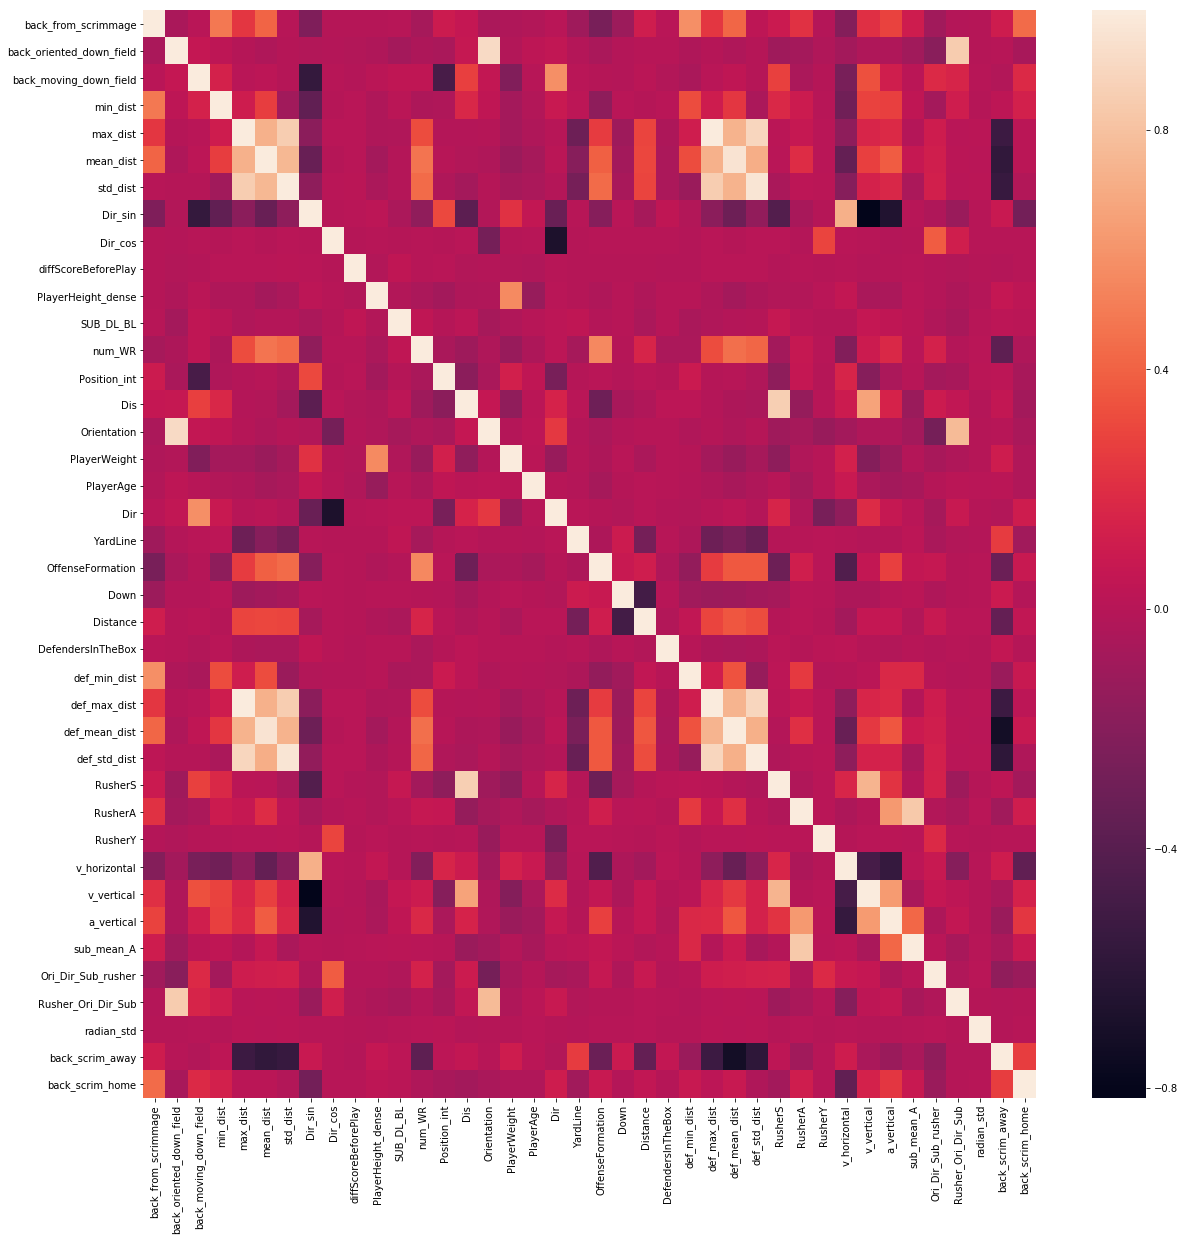

In [17]:
plt.figure(figsize=(20,20))
sns.heatmap(input_df.corr())

In [18]:
input_df.head(3)

,back_from_scrimmage,back_oriented_down_field,back_moving_down_field,min_dist,max_dist,mean_dist,std_dist,Dir_sin,Dir_cos,diffScoreBeforePlay,PlayerHeight_dense,SUB_DL_BL,num_WR,Position_int,Dis,Orientation,PlayerWeight,PlayerAge,Dir,YardLine,OffenseFormation,Down,Distance,DefendersInTheBox,def_min_dist,def_max_dist,def_mean_dist,def_std_dist,RusherS,RusherA,RusherY,v_horizontal,v_vertical,a_vertical,sub_mean_A,Ori_Dir_Sub_rusher,Rusher_Ori_Dir_Sub,radian_std,back_scrim_away,back_scrim_home
0,3.75,1,0,1.449724,22.415872,8.046559,4.873845,0.911690,-0.410878,0,70,-1,3,1,0.38,288.02,205,25.613783,114.26,45.0,7,3,2,6.0,4.593310,22.415872,9.752491,5.327299,3.63,3.35,30.53,3.309436,1.491487,1.376441,2.158182,68.000000,173.76,0.914643,-3.179091,0.942727
1,4.07,1,0,0.792023,23.025872,8.614623,5.598683,0.740805,0.671721,0,70,-1,3,1,0.34,239.30,205,25.613783,47.80,53.0,7,1,10,6.0,4.287773,23.025872,10.297028,5.833217,3.06,2.41,27.16,2.266862,2.055465,1.618847,0.866364,96.272727,191.50,0.921282,-3.561818,1.132727
2,3.66,1,0,1.646390,20.726285,8.482583,4.642121,0.668612,-0.743612,0,70,-1,3,1,0.60,309.18,205,25.613785,138.04,75.0,4,1,10,7.0,4.221670,20.726285,9.903689,5.073290,5.77,2.42,19.11,3.857889,4.290640,1.799541,0.953182,73.909091,171.14,0.722530,-3.389091,0.151818


In [19]:
scaler = StandardScaler()
X = scaler.fit_transform(input_df)
print(X.shape)
yards = np.array([df['Yards'][i] for i in range(0,df.shape[0],22)])
df['Yards_Label'] = df['Yards'] // 10  # use stratifiedkfold
yards_label = np.array([df['Yards_Label'][i] for i in range(0,df.shape[0],22)])
models, crpses, hist = train(X, yards, yards_label=yards_label, step=2, fold=5)

(23171, 40)
validation shape 2
Epoch 1/250
18534/18534 [==============================] - 1s 46us/step - loss: 5.8097

Epoch 00001: CRPS_score_val improved from inf to 0.08209, saving model to best_model_1.h5
Epoch 2/250
18534/18534 [==============================] - 0s 4us/step - loss: 5.3516

Epoch 00002: CRPS_score_val improved from 0.08209 to 0.07246, saving model to best_model_1.h5
Epoch 3/250
18534/18534 [==============================] - 0s 5us/step - loss: 4.8833

Epoch 00003: CRPS_score_val improved from 0.07246 to 0.05605, saving model to best_model_1.h5
Epoch 4/250
18534/18534 [==============================] - 0s 4us/step - loss: 4.3418

Epoch 00004: CRPS_score_val improved from 0.05605 to 0.03401, saving model to best_model_1.h5
Epoch 5/250
18534/18534 [==============================] - 0s 10us/step - loss: 3.8078

Epoch 00005: CRPS_score_val improved from 0.03401 to 0.01842, saving model to best_model_1.h5
Epoch 6/250
18534/18534 [==============================] - 0s 4us/

18534/18534 [==============================] - 0s 6us/step - loss: 2.7562

Epoch 00048: CRPS_score_val improved from 0.01307 to 0.01306, saving model to best_model_1.h5
Epoch 49/250
18534/18534 [==============================] - 0s 4us/step - loss: 2.7568

Epoch 00049: CRPS_score_val did not improve from 0.01306
Epoch 50/250
18534/18534 [==============================] - 0s 6us/step - loss: 2.7594

Epoch 00050: CRPS_score_val improved from 0.01306 to 0.01306, saving model to best_model_1.h5
Epoch 51/250
18534/18534 [==============================] - 0s 6us/step - loss: 2.7535

Epoch 00051: CRPS_score_val improved from 0.01306 to 0.01305, saving model to best_model_1.h5
Epoch 52/250
18534/18534 [==============================] - 0s 5us/step - loss: 2.7532

Epoch 00052: CRPS_score_val improved from 0.01305 to 0.01304, saving model to best_model_1.h5
Epoch 53/250
18534/18534 [==============================] - 0s 8us/step - loss: 2.7550

Epoch 00053: CRPS_score_val improved from 0.01304 to

18534/18534 [==============================] - 0s 5us/step - loss: 2.6985

Epoch 00096: CRPS_score_val did not improve from 0.01290
Epoch 97/250
18534/18534 [==============================] - 0s 5us/step - loss: 2.7002

Epoch 00097: CRPS_score_val improved from 0.01290 to 0.01289, saving model to best_model_1.h5
Epoch 98/250
18534/18534 [==============================] - 0s 7us/step - loss: 2.6929

Epoch 00098: CRPS_score_val did not improve from 0.01289
Epoch 99/250
18534/18534 [==============================] - 0s 5us/step - loss: 2.6959

Epoch 00099: CRPS_score_val improved from 0.01289 to 0.01288, saving model to best_model_1.h5
Epoch 100/250
18534/18534 [==============================] - 0s 6us/step - loss: 2.6973

Epoch 00100: CRPS_score_val improved from 0.01288 to 0.01288, saving model to best_model_1.h5
Epoch 101/250
18534/18534 [==============================] - 0s 4us/step - loss: 2.6935

Epoch 00101: CRPS_score_val improved from 0.01288 to 0.01288, saving model to best_mode

18534/18534 [==============================] - 0s 6us/step - loss: 2.6410

Epoch 00146: CRPS_score_val did not improve from 0.01282
Epoch 147/250
18534/18534 [==============================] - 0s 5us/step - loss: 2.6411

Epoch 00147: CRPS_score_val did not improve from 0.01282
Epoch 148/250
18534/18534 [==============================] - 0s 6us/step - loss: 2.6418

Epoch 00148: CRPS_score_val did not improve from 0.01282
Epoch 149/250
18534/18534 [==============================] - 0s 5us/step - loss: 2.6410

Epoch 00149: CRPS_score_val did not improve from 0.01282
Epoch 150/250
18534/18534 [==============================] - 0s 5us/step - loss: 2.6380

Epoch 00150: CRPS_score_val did not improve from 0.01282
Epoch 151/250
18534/18534 [==============================] - 0s 6us/step - loss: 2.6343

Epoch 00151: CRPS_score_val did not improve from 0.01282
Epoch 152/250
18534/18534 [==============================] - 0s 5us/step - loss: 2.6373

Epoch 00152: CRPS_score_val improved from 0.01282

18534/18534 [==============================] - 0s 5us/step - loss: 2.5826

Epoch 00200: CRPS_score_val did not improve from 0.01278
Epoch 201/250
18534/18534 [==============================] - 0s 7us/step - loss: 2.5800

Epoch 00201: CRPS_score_val did not improve from 0.01278
Epoch 202/250
18534/18534 [==============================] - 0s 5us/step - loss: 2.5741

Epoch 00202: CRPS_score_val did not improve from 0.01278
Epoch 203/250
18534/18534 [==============================] - 0s 6us/step - loss: 2.5747

Epoch 00203: CRPS_score_val did not improve from 0.01278
Epoch 204/250
18534/18534 [==============================] - 0s 6us/step - loss: 2.5731

Epoch 00204: CRPS_score_val did not improve from 0.01278
Epoch 205/250
18534/18534 [==============================] - 0s 5us/step - loss: 2.5777

Epoch 00205: CRPS_score_val did not improve from 0.01278
Epoch 206/250
18534/18534 [==============================] - 0s 6us/step - loss: 2.5782

Epoch 00206: CRPS_score_val did not improve from 

18535/18535 [==============================] - 0s 7us/step - loss: 3.8233

Epoch 00005: CRPS_score_val improved from 0.03388 to 0.01821, saving model to best_model_2.h5
Epoch 6/250
18535/18535 [==============================] - 0s 4us/step - loss: 3.4661

Epoch 00006: CRPS_score_val improved from 0.01821 to 0.01400, saving model to best_model_2.h5
Epoch 7/250
18535/18535 [==============================] - 0s 8us/step - loss: 3.2740

Epoch 00007: CRPS_score_val improved from 0.01400 to 0.01328, saving model to best_model_2.h5
Epoch 8/250
18535/18535 [==============================] - 0s 8us/step - loss: 3.1406

Epoch 00008: CRPS_score_val improved from 0.01328 to 0.01312, saving model to best_model_2.h5
Epoch 9/250
18535/18535 [==============================] - 0s 6us/step - loss: 3.0721

Epoch 00009: CRPS_score_val improved from 0.01312 to 0.01309, saving model to best_model_2.h5
Epoch 10/250
18535/18535 [==============================] - 0s 8us/step - loss: 3.0193

Epoch 00010: CRPS_s

18535/18535 [==============================] - 0s 4us/step - loss: 2.7542

Epoch 00054: CRPS_score_val improved from 0.01292 to 0.01291, saving model to best_model_2.h5
Epoch 55/250
18535/18535 [==============================] - 0s 6us/step - loss: 2.7567

Epoch 00055: CRPS_score_val did not improve from 0.01291
Epoch 56/250
18535/18535 [==============================] - 0s 6us/step - loss: 2.7504

Epoch 00056: CRPS_score_val did not improve from 0.01291
Epoch 57/250
18535/18535 [==============================] - 0s 6us/step - loss: 2.7479

Epoch 00057: CRPS_score_val improved from 0.01291 to 0.01291, saving model to best_model_2.h5
Epoch 58/250
18535/18535 [==============================] - 0s 6us/step - loss: 2.7527

Epoch 00058: CRPS_score_val improved from 0.01291 to 0.01291, saving model to best_model_2.h5
Epoch 59/250
18535/18535 [==============================] - 0s 6us/step - loss: 2.7485

Epoch 00059: CRPS_score_val did not improve from 0.01291
Epoch 60/250
18535/18535 [======

18535/18535 [==============================] - 0s 5us/step - loss: 2.6948

Epoch 00103: CRPS_score_val did not improve from 0.01272
Epoch 104/250
18535/18535 [==============================] - 0s 5us/step - loss: 2.6946

Epoch 00104: CRPS_score_val improved from 0.01272 to 0.01272, saving model to best_model_2.h5
Epoch 105/250
18535/18535 [==============================] - 0s 7us/step - loss: 2.6928

Epoch 00105: CRPS_score_val improved from 0.01272 to 0.01271, saving model to best_model_2.h5
Epoch 106/250
18535/18535 [==============================] - 0s 6us/step - loss: 2.6915

Epoch 00106: CRPS_score_val improved from 0.01271 to 0.01271, saving model to best_model_2.h5
Epoch 107/250
18535/18535 [==============================] - 0s 5us/step - loss: 2.6909

Epoch 00107: CRPS_score_val did not improve from 0.01271
Epoch 108/250
18535/18535 [==============================] - 0s 5us/step - loss: 2.6906

Epoch 00108: CRPS_score_val improved from 0.01271 to 0.01270, saving model to best_m

18535/18535 [==============================] - 0s 6us/step - loss: 2.6380

Epoch 00154: CRPS_score_val did not improve from 0.01263
Epoch 155/250
18535/18535 [==============================] - 0s 5us/step - loss: 2.6343

Epoch 00155: CRPS_score_val did not improve from 0.01263
Epoch 156/250
18535/18535 [==============================] - 0s 6us/step - loss: 2.6343

Epoch 00156: CRPS_score_val improved from 0.01263 to 0.01262, saving model to best_model_2.h5
Epoch 157/250
18535/18535 [==============================] - 0s 8us/step - loss: 2.6347

Epoch 00157: CRPS_score_val did not improve from 0.01262
Epoch 158/250
18535/18535 [==============================] - 0s 5us/step - loss: 2.6344

Epoch 00158: CRPS_score_val did not improve from 0.01262
Epoch 159/250
18535/18535 [==============================] - 0s 5us/step - loss: 2.6345

Epoch 00159: CRPS_score_val improved from 0.01262 to 0.01262, saving model to best_model_2.h5
Epoch 160/250
18535/18535 [==============================] - 0s 

18535/18535 [==============================] - 0s 6us/step - loss: 2.5738

Epoch 00209: CRPS_score_val did not improve from 0.01260
Epoch 210/250
18535/18535 [==============================] - 0s 5us/step - loss: 2.5689

Epoch 00210: CRPS_score_val did not improve from 0.01260
Epoch 211/250
18535/18535 [==============================] - 0s 6us/step - loss: 2.5696

Epoch 00211: CRPS_score_val did not improve from 0.01260
Epoch 212/250
18535/18535 [==============================] - 0s 8us/step - loss: 2.5736

Epoch 00212: CRPS_score_val did not improve from 0.01260
Epoch 213/250
18535/18535 [==============================] - 0s 5us/step - loss: 2.5647

Epoch 00213: CRPS_score_val did not improve from 0.01260
Epoch 214/250
18535/18535 [==============================] - 0s 5us/step - loss: 2.5673

Epoch 00214: CRPS_score_val did not improve from 0.01260
Epoch 215/250
18535/18535 [==============================] - 0s 5us/step - loss: 2.5639

Epoch 00215: CRPS_score_val did not improve from 

18536/18536 [==============================] - 0s 4us/step - loss: 2.9304

Epoch 00012: CRPS_score_val improved from 0.01337 to 0.01335, saving model to best_model_3.h5
Epoch 13/250
18536/18536 [==============================] - 0s 4us/step - loss: 2.9098

Epoch 00013: CRPS_score_val did not improve from 0.01335
Epoch 14/250
18536/18536 [==============================] - 0s 5us/step - loss: 2.8993

Epoch 00014: CRPS_score_val improved from 0.01335 to 0.01334, saving model to best_model_3.h5
Epoch 15/250
18536/18536 [==============================] - 0s 7us/step - loss: 2.8762

Epoch 00015: CRPS_score_val did not improve from 0.01334
Epoch 16/250
18536/18536 [==============================] - 0s 4us/step - loss: 2.8638

Epoch 00016: CRPS_score_val improved from 0.01334 to 0.01333, saving model to best_model_3.h5
Epoch 17/250
18536/18536 [==============================] - 0s 5us/step - loss: 2.8603

Epoch 00017: CRPS_score_val did not improve from 0.01333
Epoch 18/250
18536/18536 [======

18536/18536 [==============================] - 0s 6us/step - loss: 2.7432

Epoch 00061: CRPS_score_val improved from 0.01313 to 0.01312, saving model to best_model_3.h5
Epoch 62/250
18536/18536 [==============================] - 0s 5us/step - loss: 2.7370

Epoch 00062: CRPS_score_val improved from 0.01312 to 0.01311, saving model to best_model_3.h5
Epoch 63/250
18536/18536 [==============================] - 0s 6us/step - loss: 2.7351

Epoch 00063: CRPS_score_val did not improve from 0.01311
Epoch 64/250
18536/18536 [==============================] - 0s 5us/step - loss: 2.7299

Epoch 00064: CRPS_score_val improved from 0.01311 to 0.01310, saving model to best_model_3.h5
Epoch 65/250
18536/18536 [==============================] - 0s 8us/step - loss: 2.7336

Epoch 00065: CRPS_score_val improved from 0.01310 to 0.01310, saving model to best_model_3.h5
Epoch 66/250
18536/18536 [==============================] - 0s 4us/step - loss: 2.7339

Epoch 00066: CRPS_score_val improved from 0.01310 to


Epoch 00109: CRPS_score_val did not improve from 0.01292
Epoch 110/250
18536/18536 [==============================] - 0s 5us/step - loss: 2.6820

Epoch 00110: CRPS_score_val did not improve from 0.01292
Epoch 111/250
18536/18536 [==============================] - 0s 7us/step - loss: 2.6802

Epoch 00111: CRPS_score_val improved from 0.01292 to 0.01292, saving model to best_model_3.h5
Epoch 112/250
18536/18536 [==============================] - 0s 7us/step - loss: 2.6783

Epoch 00112: CRPS_score_val improved from 0.01292 to 0.01292, saving model to best_model_3.h5
Epoch 113/250
18536/18536 [==============================] - 0s 5us/step - loss: 2.6780

Epoch 00113: CRPS_score_val improved from 0.01292 to 0.01291, saving model to best_model_3.h5
Epoch 114/250
18536/18536 [==============================] - 0s 4us/step - loss: 2.6748

Epoch 00114: CRPS_score_val did not improve from 0.01291
Epoch 115/250
18536/18536 [==============================] - 0s 5us/step - loss: 2.6733

Epoch 00115:

18536/18536 [==============================] - 0s 6us/step - loss: 2.6208

Epoch 00162: CRPS_score_val did not improve from 0.01284
Epoch 163/250
18536/18536 [==============================] - 0s 5us/step - loss: 2.6229

Epoch 00163: CRPS_score_val did not improve from 0.01284
Epoch 164/250
18536/18536 [==============================] - 0s 7us/step - loss: 2.6209

Epoch 00164: CRPS_score_val did not improve from 0.01284
Epoch 165/250
18536/18536 [==============================] - 0s 5us/step - loss: 2.6211

Epoch 00165: CRPS_score_val did not improve from 0.01284
Epoch 166/250
18536/18536 [==============================] - 0s 5us/step - loss: 2.6170

Epoch 00166: CRPS_score_val did not improve from 0.01284
Epoch 167/250
18536/18536 [==============================] - 0s 7us/step - loss: 2.6141

Epoch 00167: CRPS_score_val did not improve from 0.01284
Epoch 168/250
18536/18536 [==============================] - 0s 5us/step - loss: 2.6210

Epoch 00168: CRPS_score_val did not improve from 

18536/18536 [==============================] - 0s 6us/step - loss: 2.5520

Epoch 00218: CRPS_score_val did not improve from 0.01284
Epoch 219/250
18536/18536 [==============================] - 0s 5us/step - loss: 2.5534

Epoch 00219: CRPS_score_val did not improve from 0.01284
Epoch 220/250
18536/18536 [==============================] - 0s 10us/step - loss: 2.5533

Epoch 00220: CRPS_score_val did not improve from 0.01284
Epoch 221/250
18536/18536 [==============================] - 0s 5us/step - loss: 2.5560

Epoch 00221: CRPS_score_val did not improve from 0.01284
Epoch 222/250
18536/18536 [==============================] - 0s 5us/step - loss: 2.5528

Epoch 00222: CRPS_score_val did not improve from 0.01284
Epoch 223/250
18536/18536 [==============================] - 0s 5us/step - loss: 2.5481

Epoch 00223: CRPS_score_val did not improve from 0.01284
Epoch 224/250
18536/18536 [==============================] - 0s 5us/step - loss: 2.5453

Epoch 00224: CRPS_score_val did not improve from

18538/18538 [==============================] - 0s 4us/step - loss: 2.8293

Epoch 00020: CRPS_score_val improved from 0.01323 to 0.01322, saving model to best_model_4.h5
Epoch 21/250
18538/18538 [==============================] - 0s 4us/step - loss: 2.8242

Epoch 00021: CRPS_score_val did not improve from 0.01322
Epoch 22/250
18538/18538 [==============================] - 0s 6us/step - loss: 2.8242

Epoch 00022: CRPS_score_val improved from 0.01322 to 0.01321, saving model to best_model_4.h5
Epoch 23/250
18538/18538 [==============================] - 0s 11us/step - loss: 2.8201

Epoch 00023: CRPS_score_val did not improve from 0.01321
Epoch 24/250
18538/18538 [==============================] - 0s 5us/step - loss: 2.8073

Epoch 00024: CRPS_score_val improved from 0.01321 to 0.01321, saving model to best_model_4.h5
Epoch 25/250
18538/18538 [==============================] - 0s 6us/step - loss: 2.8042

Epoch 00025: CRPS_score_val did not improve from 0.01321
Epoch 26/250
18538/18538 [=====

18538/18538 [==============================] - 0s 7us/step - loss: 2.7268

Epoch 00069: CRPS_score_val improved from 0.01299 to 0.01299, saving model to best_model_4.h5
Epoch 70/250
18538/18538 [==============================] - 0s 4us/step - loss: 2.7306

Epoch 00070: CRPS_score_val improved from 0.01299 to 0.01298, saving model to best_model_4.h5
Epoch 71/250
18538/18538 [==============================] - 0s 5us/step - loss: 2.7254

Epoch 00071: CRPS_score_val improved from 0.01298 to 0.01298, saving model to best_model_4.h5
Epoch 72/250
18538/18538 [==============================] - 0s 6us/step - loss: 2.7238

Epoch 00072: CRPS_score_val improved from 0.01298 to 0.01297, saving model to best_model_4.h5
Epoch 73/250
18538/18538 [==============================] - 0s 7us/step - loss: 2.7199

Epoch 00073: CRPS_score_val did not improve from 0.01297
Epoch 74/250
18538/18538 [==============================] - 0s 5us/step - loss: 2.7196

Epoch 00074: CRPS_score_val improved from 0.01297 to

18538/18538 [==============================] - 0s 5us/step - loss: 2.6666

Epoch 00118: CRPS_score_val did not improve from 0.01283
Epoch 119/250
18538/18538 [==============================] - 0s 6us/step - loss: 2.6682

Epoch 00119: CRPS_score_val improved from 0.01283 to 0.01283, saving model to best_model_4.h5
Epoch 120/250
18538/18538 [==============================] - 0s 7us/step - loss: 2.6646

Epoch 00120: CRPS_score_val improved from 0.01283 to 0.01283, saving model to best_model_4.h5
Epoch 121/250
18538/18538 [==============================] - 0s 6us/step - loss: 2.6685

Epoch 00121: CRPS_score_val improved from 0.01283 to 0.01283, saving model to best_model_4.h5
Epoch 122/250
18538/18538 [==============================] - 0s 6us/step - loss: 2.6669

Epoch 00122: CRPS_score_val did not improve from 0.01283
Epoch 123/250
18538/18538 [==============================] - 0s 5us/step - loss: 2.6649

Epoch 00123: CRPS_score_val improved from 0.01283 to 0.01283, saving model to best_m

18538/18538 [==============================] - 0s 5us/step - loss: 2.6128

Epoch 00170: CRPS_score_val improved from 0.01278 to 0.01277, saving model to best_model_4.h5
Epoch 171/250
18538/18538 [==============================] - 0s 9us/step - loss: 2.6093

Epoch 00171: CRPS_score_val did not improve from 0.01277
Epoch 172/250
18538/18538 [==============================] - 0s 6us/step - loss: 2.6067

Epoch 00172: CRPS_score_val improved from 0.01277 to 0.01277, saving model to best_model_4.h5
Epoch 173/250
18538/18538 [==============================] - 0s 4us/step - loss: 2.6058

Epoch 00173: CRPS_score_val did not improve from 0.01277
Epoch 174/250
18538/18538 [==============================] - 0s 8us/step - loss: 2.6053

Epoch 00174: CRPS_score_val did not improve from 0.01277
Epoch 175/250
18538/18538 [==============================] - 0s 5us/step - loss: 2.6030

Epoch 00175: CRPS_score_val improved from 0.01277 to 0.01277, saving model to best_model_4.h5
Epoch 176/250
18538/18538 [

18538/18538 [==============================] - 0s 4us/step - loss: 2.5471

Epoch 00223: CRPS_score_val did not improve from 0.01276
Epoch 224/250
18538/18538 [==============================] - 0s 4us/step - loss: 2.5449

Epoch 00224: CRPS_score_val did not improve from 0.01276
Epoch 225/250
18538/18538 [==============================] - 0s 4us/step - loss: 2.5350

Epoch 00225: CRPS_score_val did not improve from 0.01276
Epoch 226/250
18538/18538 [==============================] - 0s 4us/step - loss: 2.5384

Epoch 00226: CRPS_score_val did not improve from 0.01276
Epoch 227/250
18538/18538 [==============================] - 0s 4us/step - loss: 2.5429

Epoch 00227: CRPS_score_val did not improve from 0.01276
Epoch 228/250
18538/18538 [==============================] - 0s 4us/step - loss: 2.5390

Epoch 00228: CRPS_score_val did not improve from 0.01276
Epoch 229/250
18538/18538 [==============================] - 0s 4us/step - loss: 2.5397

Epoch 00229: CRPS_score_val did not improve from 

18541/18541 [==============================] - 0s 4us/step - loss: 2.8217

Epoch 00023: CRPS_score_val improved from 0.01300 to 0.01299, saving model to best_model_5.h5
Epoch 24/250
18541/18541 [==============================] - 0s 5us/step - loss: 2.8154

Epoch 00024: CRPS_score_val improved from 0.01299 to 0.01299, saving model to best_model_5.h5
Epoch 25/250
18541/18541 [==============================] - 0s 7us/step - loss: 2.8057

Epoch 00025: CRPS_score_val did not improve from 0.01299
Epoch 26/250
18541/18541 [==============================] - 0s 6us/step - loss: 2.8079

Epoch 00026: CRPS_score_val improved from 0.01299 to 0.01298, saving model to best_model_5.h5
Epoch 27/250
18541/18541 [==============================] - 0s 6us/step - loss: 2.8035

Epoch 00027: CRPS_score_val improved from 0.01298 to 0.01298, saving model to best_model_5.h5
Epoch 28/250
18541/18541 [==============================] - 0s 4us/step - loss: 2.7997

Epoch 00028: CRPS_score_val improved from 0.01298 to

18541/18541 [==============================] - 0s 5us/step - loss: 2.7262

Epoch 00071: CRPS_score_val improved from 0.01280 to 0.01280, saving model to best_model_5.h5
Epoch 72/250
18541/18541 [==============================] - 0s 6us/step - loss: 2.7299

Epoch 00072: CRPS_score_val did not improve from 0.01280
Epoch 73/250
18541/18541 [==============================] - 0s 5us/step - loss: 2.7252

Epoch 00073: CRPS_score_val improved from 0.01280 to 0.01280, saving model to best_model_5.h5
Epoch 74/250
18541/18541 [==============================] - 0s 6us/step - loss: 2.7260

Epoch 00074: CRPS_score_val improved from 0.01280 to 0.01279, saving model to best_model_5.h5
Epoch 75/250
18541/18541 [==============================] - 0s 4us/step - loss: 2.7258

Epoch 00075: CRPS_score_val did not improve from 0.01279
Epoch 76/250
18541/18541 [==============================] - 0s 7us/step - loss: 2.7218

Epoch 00076: CRPS_score_val did not improve from 0.01279
Epoch 77/250
18541/18541 [======

18541/18541 [==============================] - 0s 7us/step - loss: 2.6670

Epoch 00122: CRPS_score_val improved from 0.01269 to 0.01268, saving model to best_model_5.h5
Epoch 123/250
18541/18541 [==============================] - 0s 4us/step - loss: 2.6685

Epoch 00123: CRPS_score_val improved from 0.01268 to 0.01268, saving model to best_model_5.h5
Epoch 124/250
18541/18541 [==============================] - 0s 6us/step - loss: 2.6650

Epoch 00124: CRPS_score_val improved from 0.01268 to 0.01268, saving model to best_model_5.h5
Epoch 125/250
18541/18541 [==============================] - 0s 5us/step - loss: 2.6677

Epoch 00125: CRPS_score_val did not improve from 0.01268
Epoch 126/250
18541/18541 [==============================] - 0s 7us/step - loss: 2.6644

Epoch 00126: CRPS_score_val did not improve from 0.01268
Epoch 127/250
18541/18541 [==============================] - 0s 6us/step - loss: 2.6614

Epoch 00127: CRPS_score_val did not improve from 0.01268
Epoch 128/250
18541/18541 [

18541/18541 [==============================] - 0s 5us/step - loss: 2.6061

Epoch 00175: CRPS_score_val did not improve from 0.01264
Epoch 176/250
18541/18541 [==============================] - 0s 6us/step - loss: 2.6067

Epoch 00176: CRPS_score_val improved from 0.01264 to 0.01264, saving model to best_model_5.h5
Epoch 177/250
18541/18541 [==============================] - 0s 8us/step - loss: 2.6097

Epoch 00177: CRPS_score_val did not improve from 0.01264
Epoch 178/250
18541/18541 [==============================] - 0s 5us/step - loss: 2.6061

Epoch 00178: CRPS_score_val did not improve from 0.01264
Epoch 179/250
18541/18541 [==============================] - 0s 6us/step - loss: 2.6053

Epoch 00179: CRPS_score_val did not improve from 0.01264
Epoch 180/250
18541/18541 [==============================] - 0s 7us/step - loss: 2.5984

Epoch 00180: CRPS_score_val did not improve from 0.01264
Epoch 181/250
18541/18541 [==============================] - 0s 5us/step - loss: 2.6037

Epoch 00181:

18541/18541 [==============================] - 0s 5us/step - loss: 2.5391

Epoch 00230: CRPS_score_val did not improve from 0.01262
Epoch 231/250
18541/18541 [==============================] - 0s 6us/step - loss: 2.5411

Epoch 00231: CRPS_score_val did not improve from 0.01262
Epoch 232/250
18541/18541 [==============================] - 0s 6us/step - loss: 2.5509

Epoch 00232: CRPS_score_val did not improve from 0.01262
Epoch 233/250
18541/18541 [==============================] - 0s 7us/step - loss: 2.5353

Epoch 00233: CRPS_score_val did not improve from 0.01262
Epoch 234/250
18541/18541 [==============================] - 0s 7us/step - loss: 2.5408

Epoch 00234: CRPS_score_val did not improve from 0.01262
Epoch 235/250
18541/18541 [==============================] - 0s 6us/step - loss: 2.5432

Epoch 00235: CRPS_score_val did not improve from 0.01262
Epoch 236/250
18541/18541 [==============================] - 0s 5us/step - loss: 2.5388

Epoch 00236: CRPS_score_val did not improve from 

18534/18534 [==============================] - 0s 6us/step - loss: 2.7971

Epoch 00029: CRPS_score_val did not improve from 0.01321
Epoch 30/250
18534/18534 [==============================] - 0s 6us/step - loss: 2.7956

Epoch 00030: CRPS_score_val improved from 0.01321 to 0.01320, saving model to best_model_6.h5
Epoch 31/250
18534/18534 [==============================] - 0s 9us/step - loss: 2.7900

Epoch 00031: CRPS_score_val did not improve from 0.01320
Epoch 32/250
18534/18534 [==============================] - 0s 6us/step - loss: 2.7898

Epoch 00032: CRPS_score_val did not improve from 0.01320
Epoch 33/250
18534/18534 [==============================] - 0s 5us/step - loss: 2.7829

Epoch 00033: CRPS_score_val improved from 0.01320 to 0.01320, saving model to best_model_6.h5
Epoch 34/250
18534/18534 [==============================] - 0s 8us/step - loss: 2.7896

Epoch 00034: CRPS_score_val did not improve from 0.01320
Epoch 35/250
18534/18534 [==============================] - 0s 5us/st

18534/18534 [==============================] - 0s 10us/step - loss: 2.7189

Epoch 00078: CRPS_score_val did not improve from 0.01302
Epoch 79/250
18534/18534 [==============================] - 0s 5us/step - loss: 2.7166

Epoch 00079: CRPS_score_val improved from 0.01302 to 0.01301, saving model to best_model_6.h5
Epoch 80/250
18534/18534 [==============================] - 0s 7us/step - loss: 2.7202

Epoch 00080: CRPS_score_val improved from 0.01301 to 0.01300, saving model to best_model_6.h5
Epoch 81/250
18534/18534 [==============================] - 0s 6us/step - loss: 2.7125

Epoch 00081: CRPS_score_val did not improve from 0.01300
Epoch 82/250
18534/18534 [==============================] - 0s 5us/step - loss: 2.7124

Epoch 00082: CRPS_score_val improved from 0.01300 to 0.01300, saving model to best_model_6.h5
Epoch 83/250
18534/18534 [==============================] - 0s 8us/step - loss: 2.7141

Epoch 00083: CRPS_score_val improved from 0.01300 to 0.01300, saving model to best_model

18534/18534 [==============================] - 0s 7us/step - loss: 2.9154

Epoch 00013: CRPS_score_val improved from 0.01332 to 0.01332, saving model to best_model_7.h5
Epoch 14/250
18534/18534 [==============================] - 0s 8us/step - loss: 2.8853

Epoch 00014: CRPS_score_val improved from 0.01332 to 0.01331, saving model to best_model_7.h5
Epoch 15/250
18534/18534 [==============================] - 0s 5us/step - loss: 2.8834

Epoch 00015: CRPS_score_val improved from 0.01331 to 0.01331, saving model to best_model_7.h5
Epoch 16/250
18534/18534 [==============================] - 0s 8us/step - loss: 2.8655

Epoch 00016: CRPS_score_val improved from 0.01331 to 0.01331, saving model to best_model_7.h5
Epoch 17/250
18534/18534 [==============================] - 0s 9us/step - loss: 2.8529

Epoch 00017: CRPS_score_val improved from 0.01331 to 0.01329, saving model to best_model_7.h5
Epoch 18/250
18534/18534 [==============================] - 0s 5us/step - loss: 2.8400

Epoch 00018: CR

18534/18534 [==============================] - 0s 6us/step - loss: 2.7365

Epoch 00062: CRPS_score_val did not improve from 0.01309
Epoch 63/250
18534/18534 [==============================] - 0s 6us/step - loss: 2.7417

Epoch 00063: CRPS_score_val improved from 0.01309 to 0.01308, saving model to best_model_7.h5
Epoch 64/250
18534/18534 [==============================] - 0s 4us/step - loss: 2.7369

Epoch 00064: CRPS_score_val improved from 0.01308 to 0.01307, saving model to best_model_7.h5
Epoch 65/250
18534/18534 [==============================] - 0s 8us/step - loss: 2.7338

Epoch 00065: CRPS_score_val improved from 0.01307 to 0.01307, saving model to best_model_7.h5
Epoch 66/250
18534/18534 [==============================] - 0s 5us/step - loss: 2.7367

Epoch 00066: CRPS_score_val did not improve from 0.01307
Epoch 67/250
18534/18534 [==============================] - 0s 7us/step - loss: 2.7328

Epoch 00067: CRPS_score_val did not improve from 0.01307
Epoch 68/250
18534/18534 [======

18534/18534 [==============================] - 0s 6us/step - loss: 2.6804

Epoch 00110: CRPS_score_val did not improve from 0.01292
Epoch 111/250
18534/18534 [==============================] - 0s 5us/step - loss: 2.6814

Epoch 00111: CRPS_score_val did not improve from 0.01292
Epoch 112/250
18534/18534 [==============================] - 0s 5us/step - loss: 2.6792

Epoch 00112: CRPS_score_val did not improve from 0.01292
Epoch 113/250
18534/18534 [==============================] - 0s 5us/step - loss: 2.6731

Epoch 00113: CRPS_score_val improved from 0.01292 to 0.01292, saving model to best_model_7.h5
Epoch 114/250
18534/18534 [==============================] - 0s 4us/step - loss: 2.6709

Epoch 00114: CRPS_score_val did not improve from 0.01292
Epoch 115/250
18534/18534 [==============================] - 0s 5us/step - loss: 2.6728

Epoch 00115: CRPS_score_val improved from 0.01292 to 0.01292, saving model to best_model_7.h5
Epoch 116/250
18534/18534 [==============================] - 0s 

18534/18534 [==============================] - 0s 4us/step - loss: 2.6183

Epoch 00163: CRPS_score_val did not improve from 0.01286
Epoch 164/250
18534/18534 [==============================] - 0s 5us/step - loss: 2.6167

Epoch 00164: CRPS_score_val did not improve from 0.01286
Epoch 165/250
18534/18534 [==============================] - 0s 5us/step - loss: 2.6158

Epoch 00165: CRPS_score_val did not improve from 0.01286
Epoch 166/250
18534/18534 [==============================] - 0s 5us/step - loss: 2.6197

Epoch 00166: CRPS_score_val did not improve from 0.01286
Epoch 167/250
18534/18534 [==============================] - 0s 5us/step - loss: 2.6134

Epoch 00167: CRPS_score_val improved from 0.01286 to 0.01286, saving model to best_model_7.h5
Epoch 168/250
18534/18534 [==============================] - 0s 5us/step - loss: 2.6115

Epoch 00168: CRPS_score_val did not improve from 0.01286
Epoch 169/250
18534/18534 [==============================] - 0s 5us/step - loss: 2.6122

Epoch 00169:

18534/18534 [==============================] - 0s 5us/step - loss: 2.5593

Epoch 00217: CRPS_score_val did not improve from 0.01284
Epoch 218/250
18534/18534 [==============================] - 0s 8us/step - loss: 2.5523

Epoch 00218: CRPS_score_val did not improve from 0.01284
Epoch 219/250
18534/18534 [==============================] - 0s 6us/step - loss: 2.5455

Epoch 00219: CRPS_score_val did not improve from 0.01284
Epoch 220/250
18534/18534 [==============================] - 0s 8us/step - loss: 2.5442

Epoch 00220: CRPS_score_val did not improve from 0.01284
Epoch 221/250
18534/18534 [==============================] - 0s 6us/step - loss: 2.5508

Epoch 00221: CRPS_score_val did not improve from 0.01284
Epoch 222/250
18534/18534 [==============================] - 0s 9us/step - loss: 2.5543

Epoch 00222: CRPS_score_val did not improve from 0.01284
Epoch 223/250
18534/18534 [==============================] - 0s 5us/step - loss: 2.5453

Epoch 00223: CRPS_score_val did not improve from 

18537/18537 [==============================] - 0s 5us/step - loss: 2.8379

Epoch 00019: CRPS_score_val improved from 0.01309 to 0.01308, saving model to best_model_8.h5
Epoch 20/250
18537/18537 [==============================] - 0s 13us/step - loss: 2.8415

Epoch 00020: CRPS_score_val did not improve from 0.01308
Epoch 21/250
18537/18537 [==============================] - 0s 8us/step - loss: 2.8289

Epoch 00021: CRPS_score_val improved from 0.01308 to 0.01308, saving model to best_model_8.h5
Epoch 22/250
18537/18537 [==============================] - 0s 6us/step - loss: 2.8188

Epoch 00022: CRPS_score_val did not improve from 0.01308
Epoch 23/250
18537/18537 [==============================] - 0s 6us/step - loss: 2.8204

Epoch 00023: CRPS_score_val improved from 0.01308 to 0.01308, saving model to best_model_8.h5
Epoch 24/250
18537/18537 [==============================] - 0s 5us/step - loss: 2.8134

Epoch 00024: CRPS_score_val improved from 0.01308 to 0.01307, saving model to best_model

18537/18537 [==============================] - 0s 6us/step - loss: 2.7335

Epoch 00066: CRPS_score_val improved from 0.01291 to 0.01291, saving model to best_model_8.h5
Epoch 67/250
18537/18537 [==============================] - 0s 6us/step - loss: 2.7355

Epoch 00067: CRPS_score_val improved from 0.01291 to 0.01290, saving model to best_model_8.h5
Epoch 68/250
18537/18537 [==============================] - 0s 8us/step - loss: 2.7366

Epoch 00068: CRPS_score_val did not improve from 0.01290
Epoch 69/250
18537/18537 [==============================] - 0s 6us/step - loss: 2.7326

Epoch 00069: CRPS_score_val improved from 0.01290 to 0.01290, saving model to best_model_8.h5
Epoch 70/250
18537/18537 [==============================] - 0s 5us/step - loss: 2.7313

Epoch 00070: CRPS_score_val improved from 0.01290 to 0.01290, saving model to best_model_8.h5
Epoch 71/250
18537/18537 [==============================] - 0s 4us/step - loss: 2.7293

Epoch 00071: CRPS_score_val improved from 0.01290 to

18537/18537 [==============================] - 0s 7us/step - loss: 2.6811

Epoch 00114: CRPS_score_val improved from 0.01277 to 0.01277, saving model to best_model_8.h5
Epoch 115/250
18537/18537 [==============================] - 0s 7us/step - loss: 2.6739

Epoch 00115: CRPS_score_val did not improve from 0.01277
Epoch 116/250
18537/18537 [==============================] - 0s 5us/step - loss: 2.6782

Epoch 00116: CRPS_score_val did not improve from 0.01277
Epoch 117/250
18537/18537 [==============================] - 0s 7us/step - loss: 2.6750

Epoch 00117: CRPS_score_val improved from 0.01277 to 0.01276, saving model to best_model_8.h5
Epoch 118/250
18537/18537 [==============================] - 0s 5us/step - loss: 2.6747

Epoch 00118: CRPS_score_val did not improve from 0.01276
Epoch 119/250
18537/18537 [==============================] - 0s 5us/step - loss: 2.6730

Epoch 00119: CRPS_score_val did not improve from 0.01276
Epoch 120/250
18537/18537 [==============================] - 0s 

18537/18537 [==============================] - 0s 6us/step - loss: 2.6262

Epoch 00167: CRPS_score_val did not improve from 0.01273
Epoch 168/250
18537/18537 [==============================] - 0s 6us/step - loss: 2.6229

Epoch 00168: CRPS_score_val did not improve from 0.01273
Epoch 169/250
18537/18537 [==============================] - 0s 6us/step - loss: 2.6183

Epoch 00169: CRPS_score_val did not improve from 0.01273
Epoch 170/250
18537/18537 [==============================] - 0s 4us/step - loss: 2.6193

Epoch 00170: CRPS_score_val did not improve from 0.01273
Epoch 171/250
18537/18537 [==============================] - 0s 9us/step - loss: 2.6164

Epoch 00171: CRPS_score_val did not improve from 0.01273
Epoch 172/250
18537/18537 [==============================] - 0s 5us/step - loss: 2.6185

Epoch 00172: CRPS_score_val improved from 0.01273 to 0.01273, saving model to best_model_8.h5
Epoch 173/250
18537/18537 [==============================] - 0s 7us/step - loss: 2.6116

Epoch 00173:

18537/18537 [==============================] - 0s 10us/step - loss: 2.5575

Epoch 00222: CRPS_score_val did not improve from 0.01272
Epoch 223/250
18537/18537 [==============================] - 0s 5us/step - loss: 2.5615

Epoch 00223: CRPS_score_val did not improve from 0.01272
Epoch 224/250
18537/18537 [==============================] - 0s 6us/step - loss: 2.5551

Epoch 00224: CRPS_score_val did not improve from 0.01272
Epoch 225/250
18537/18537 [==============================] - 0s 6us/step - loss: 2.5557

Epoch 00225: CRPS_score_val did not improve from 0.01272
Epoch 226/250
18537/18537 [==============================] - 0s 6us/step - loss: 2.5571

Epoch 00226: CRPS_score_val did not improve from 0.01272
Epoch 227/250
18537/18537 [==============================] - 0s 8us/step - loss: 2.5553

Epoch 00227: CRPS_score_val did not improve from 0.01272
Epoch 228/250
18537/18537 [==============================] - 0s 5us/step - loss: 2.5554

Epoch 00228: CRPS_score_val did not improve from

18538/18538 [==============================] - 0s 7us/step - loss: 2.8159

Epoch 00023: CRPS_score_val improved from 0.01307 to 0.01306, saving model to best_model_9.h5
Epoch 24/250
18538/18538 [==============================] - 0s 5us/step - loss: 2.8142

Epoch 00024: CRPS_score_val improved from 0.01306 to 0.01305, saving model to best_model_9.h5
Epoch 25/250
18538/18538 [==============================] - 0s 5us/step - loss: 2.8113

Epoch 00025: CRPS_score_val improved from 0.01305 to 0.01305, saving model to best_model_9.h5
Epoch 26/250
18538/18538 [==============================] - 0s 4us/step - loss: 2.8064

Epoch 00026: CRPS_score_val improved from 0.01305 to 0.01304, saving model to best_model_9.h5
Epoch 27/250
18538/18538 [==============================] - 0s 7us/step - loss: 2.8062

Epoch 00027: CRPS_score_val did not improve from 0.01304
Epoch 28/250
18538/18538 [==============================] - 0s 6us/step - loss: 2.8001

Epoch 00028: CRPS_score_val did not improve from 0.0

18538/18538 [==============================] - 0s 5us/step - loss: 2.7257

Epoch 00072: CRPS_score_val improved from 0.01287 to 0.01287, saving model to best_model_9.h5
Epoch 73/250
18538/18538 [==============================] - 0s 4us/step - loss: 2.7254

Epoch 00073: CRPS_score_val improved from 0.01287 to 0.01287, saving model to best_model_9.h5
Epoch 74/250
18538/18538 [==============================] - 0s 5us/step - loss: 2.7249

Epoch 00074: CRPS_score_val did not improve from 0.01287
Epoch 75/250
18538/18538 [==============================] - 0s 6us/step - loss: 2.7231

Epoch 00075: CRPS_score_val improved from 0.01287 to 0.01287, saving model to best_model_9.h5
Epoch 76/250
18538/18538 [==============================] - 0s 6us/step - loss: 2.7252

Epoch 00076: CRPS_score_val improved from 0.01287 to 0.01285, saving model to best_model_9.h5
Epoch 77/250
18538/18538 [==============================] - 0s 6us/step - loss: 2.7216

Epoch 00077: CRPS_score_val did not improve from 0.0

18538/18538 [==============================] - 0s 6us/step - loss: 2.6719

Epoch 00121: CRPS_score_val improved from 0.01274 to 0.01274, saving model to best_model_9.h5
Epoch 122/250
18538/18538 [==============================] - 0s 5us/step - loss: 2.6733

Epoch 00122: CRPS_score_val did not improve from 0.01274
Epoch 123/250
18538/18538 [==============================] - 0s 5us/step - loss: 2.6673

Epoch 00123: CRPS_score_val improved from 0.01274 to 0.01273, saving model to best_model_9.h5
Epoch 124/250
18538/18538 [==============================] - 0s 6us/step - loss: 2.6648

Epoch 00124: CRPS_score_val did not improve from 0.01273
Epoch 125/250
18538/18538 [==============================] - 0s 6us/step - loss: 2.6648

Epoch 00125: CRPS_score_val did not improve from 0.01273
Epoch 126/250
18538/18538 [==============================] - 0s 5us/step - loss: 2.6630

Epoch 00126: CRPS_score_val improved from 0.01273 to 0.01273, saving model to best_model_9.h5
Epoch 127/250
18538/18538 [

18538/18538 [==============================] - 0s 6us/step - loss: 2.6111

Epoch 00173: CRPS_score_val did not improve from 0.01268
Epoch 174/250
18538/18538 [==============================] - 0s 6us/step - loss: 2.6190

Epoch 00174: CRPS_score_val did not improve from 0.01268
Epoch 175/250
18538/18538 [==============================] - 0s 7us/step - loss: 2.6117

Epoch 00175: CRPS_score_val improved from 0.01268 to 0.01268, saving model to best_model_9.h5
Epoch 176/250
18538/18538 [==============================] - 0s 6us/step - loss: 2.6081

Epoch 00176: CRPS_score_val did not improve from 0.01268
Epoch 177/250
18538/18538 [==============================] - 0s 6us/step - loss: 2.6135

Epoch 00177: CRPS_score_val did not improve from 0.01268
Epoch 178/250
18538/18538 [==============================] - 0s 5us/step - loss: 2.6070

Epoch 00178: CRPS_score_val did not improve from 0.01268
Epoch 179/250
18538/18538 [==============================] - 0s 5us/step - loss: 2.6086

Epoch 00179:

18538/18538 [==============================] - 0s 5us/step - loss: 2.5476

Epoch 00229: CRPS_score_val did not improve from 0.01267
Epoch 230/250
18538/18538 [==============================] - 0s 5us/step - loss: 2.5495

Epoch 00230: CRPS_score_val did not improve from 0.01267
Epoch 231/250
18538/18538 [==============================] - 0s 5us/step - loss: 2.5466

Epoch 00231: CRPS_score_val did not improve from 0.01267
Epoch 232/250
18538/18538 [==============================] - 0s 6us/step - loss: 2.5467

Epoch 00232: CRPS_score_val did not improve from 0.01267
Epoch 233/250
18538/18538 [==============================] - 0s 4us/step - loss: 2.5392

Epoch 00233: CRPS_score_val did not improve from 0.01267
Epoch 234/250
18538/18538 [==============================] - 0s 6us/step - loss: 2.5490

Epoch 00234: CRPS_score_val did not improve from 0.01267
Epoch 235/250
18538/18538 [==============================] - 0s 6us/step - loss: 2.5422

Epoch 00235: CRPS_score_val did not improve from 

18541/18541 [==============================] - 0s 5us/step - loss: 2.7945

Epoch 00029: CRPS_score_val did not improve from 0.01303
Epoch 30/250
18541/18541 [==============================] - 0s 6us/step - loss: 2.7957

Epoch 00030: CRPS_score_val improved from 0.01303 to 0.01302, saving model to best_model_10.h5
Epoch 31/250
18541/18541 [==============================] - 0s 5us/step - loss: 2.7926

Epoch 00031: CRPS_score_val improved from 0.01302 to 0.01302, saving model to best_model_10.h5
Epoch 32/250
18541/18541 [==============================] - 0s 6us/step - loss: 2.7913

Epoch 00032: CRPS_score_val improved from 0.01302 to 0.01301, saving model to best_model_10.h5
Epoch 33/250
18541/18541 [==============================] - 0s 6us/step - loss: 2.7850

Epoch 00033: CRPS_score_val did not improve from 0.01301
Epoch 34/250
18541/18541 [==============================] - 0s 5us/step - loss: 2.7886

Epoch 00034: CRPS_score_val did not improve from 0.01301
Epoch 35/250
18541/18541 [===

18541/18541 [==============================] - 0s 7us/step - loss: 2.7189

Epoch 00077: CRPS_score_val improved from 0.01281 to 0.01280, saving model to best_model_10.h5
Epoch 78/250
18541/18541 [==============================] - 0s 4us/step - loss: 2.7209

Epoch 00078: CRPS_score_val improved from 0.01280 to 0.01280, saving model to best_model_10.h5
Epoch 79/250
18541/18541 [==============================] - 0s 6us/step - loss: 2.7220

Epoch 00079: CRPS_score_val did not improve from 0.01280
Epoch 80/250
18541/18541 [==============================] - 0s 5us/step - loss: 2.7152

Epoch 00080: CRPS_score_val improved from 0.01280 to 0.01280, saving model to best_model_10.h5
Epoch 81/250
18541/18541 [==============================] - 0s 7us/step - loss: 2.7155

Epoch 00081: CRPS_score_val improved from 0.01280 to 0.01278, saving model to best_model_10.h5
Epoch 82/250
18541/18541 [==============================] - 0s 5us/step - loss: 2.7149

Epoch 00082: CRPS_score_val improved from 0.0127

18541/18541 [==============================] - 0s 5us/step - loss: 2.6658

Epoch 00127: CRPS_score_val did not improve from 0.01264
Epoch 128/250
18541/18541 [==============================] - 0s 7us/step - loss: 2.6621

Epoch 00128: CRPS_score_val improved from 0.01264 to 0.01264, saving model to best_model_10.h5
Epoch 129/250
18541/18541 [==============================] - 0s 11us/step - loss: 2.6660

Epoch 00129: CRPS_score_val improved from 0.01264 to 0.01263, saving model to best_model_10.h5
Epoch 130/250
18541/18541 [==============================] - 0s 9us/step - loss: 2.6585

Epoch 00130: CRPS_score_val did not improve from 0.01263
Epoch 131/250
18541/18541 [==============================] - 0s 5us/step - loss: 2.6588

Epoch 00131: CRPS_score_val improved from 0.01263 to 0.01263, saving model to best_model_10.h5
Epoch 132/250
18541/18541 [==============================] - 0s 7us/step - loss: 2.6585

Epoch 00132: CRPS_score_val did not improve from 0.01263
Epoch 133/250
18541/185

18541/18541 [==============================] - 0s 6us/step - loss: 2.6027

Epoch 00180: CRPS_score_val improved from 0.01257 to 0.01257, saving model to best_model_10.h5
Epoch 181/250
18541/18541 [==============================] - 0s 7us/step - loss: 2.6086

Epoch 00181: CRPS_score_val improved from 0.01257 to 0.01257, saving model to best_model_10.h5
Epoch 182/250
18541/18541 [==============================] - 0s 10us/step - loss: 2.6060

Epoch 00182: CRPS_score_val did not improve from 0.01257
Epoch 183/250
18541/18541 [==============================] - 0s 5us/step - loss: 2.6008

Epoch 00183: CRPS_score_val did not improve from 0.01257
Epoch 184/250
18541/18541 [==============================] - 0s 7us/step - loss: 2.5967

Epoch 00184: CRPS_score_val improved from 0.01257 to 0.01256, saving model to best_model_10.h5
Epoch 185/250
18541/18541 [==============================] - 0s 8us/step - loss: 2.6005

Epoch 00185: CRPS_score_val did not improve from 0.01256
Epoch 186/250
18541/185

18541/18541 [==============================] - 0s 7us/step - loss: 2.5373

Epoch 00235: CRPS_score_val did not improve from 0.01256
Epoch 236/250
18541/18541 [==============================] - 0s 7us/step - loss: 2.5420

Epoch 00236: CRPS_score_val did not improve from 0.01256
Epoch 237/250
18541/18541 [==============================] - 0s 7us/step - loss: 2.5285

Epoch 00237: CRPS_score_val did not improve from 0.01256
Epoch 238/250
18541/18541 [==============================] - 0s 9us/step - loss: 2.5325

Epoch 00238: CRPS_score_val did not improve from 0.01256
Epoch 239/250
18541/18541 [==============================] - 0s 6us/step - loss: 2.5354

Epoch 00239: CRPS_score_val did not improve from 0.01256
Epoch 240/250
18541/18541 [==============================] - 0s 5us/step - loss: 2.5336

Epoch 00240: CRPS_score_val did not improve from 0.01256
Epoch 241/250
18541/18541 [==============================] - 0s 5us/step - loss: 2.5361

Epoch 00241: CRPS_score_val did not improve from 

In [20]:
print(X.shape)
print('crps mean: ', np.mean(crpses))
loss_sum = 0
losses = []
for i in range(10):
    loss = hist[i].history['loss'][hist[i].history['CRPS_score_val'].index(min(hist[i].history['CRPS_score_val']))]
    loss_sum += loss
    losses.append(loss)
print('loss mean: ', loss_sum/10)
print(losses)

(23171, 40)
crps mean:  0.0127242
loss mean:  2.58489519601842
[2.5802155331885066, 2.5982338079262655, 2.625613527870096, 2.5236570005059846, 2.5603941737830747, 2.610037950297782, 2.5793149141968423, 2.5873021923068684, 2.5853961760049398, 2.5987866841038416]


## 6. Predict

In [21]:
if  TRAIN_OFFLINE==True:
    basetable = create_feature(df.iloc[:22, :],
                               fix_ori=fix_ori,
                              ori_dir_sub=ori_dir_sub,
                              process_acc=process_acc,
                              process_ori_sub=process_ori_sub,
                              process_radian=process_radian,
                              process_xy_std=process_xy_std,
                               process_scrim=process_scrim,
                              fillna=fillna)
    
    scaled_basetable = scaler.transform(basetable)
    y_pred = predict(scaled_basetable, models=models)
    y_pred = np.clip(np.cumsum(y_pred, axis=1), 0, 1).tolist()[0]
    print(len(y_pred))
    print(y_pred)

elif  TRAIN_OFFLINE==False:
    from kaggle.competitions import nflrush
    import tqdm
    env = nflrush.make_env()
    iter_test = env.iter_test()

    for (test_df, sample_prediction_df) in tqdm.tqdm(iter_test):
        basetable = create_feature(test_df,
                                   fix_ori=fix_ori,
                                  ori_dir_sub=ori_dir_sub,
                                  process_acc=process_acc,
                                  process_ori_sub=process_ori_sub,
                                  process_radian=process_radian,
                                  process_xy_std=process_xy_std,
                                   process_scrim=process_scrim,
                                  fillna=fillna)
        
        scaled_basetable = scaler.transform(basetable)
        y_pred = predict(scaled_basetable, models=models)
        y_pred = np.clip(np.cumsum(y_pred, axis=1), 0, 1).tolist()[0]

        preds_df = pd.DataFrame(data=[y_pred], columns=sample_prediction_df.columns)
        env.predict(preds_df)

    env.write_submission_file()
print('done')

199
[2.2617442141381616e-07, 4.089792469130771e-07, 6.23125515630818e-07, 8.185892284018337e-07, 9.92626155493781e-07, 1.1880111969730933e-06, 1.3801779914501822e-06, 1.5623670606146334e-06, 1.7760548871592619e-06, 1.9632498151622713e-06, 2.161582870030543e-06, 2.3738568870612653e-06, 2.641987521201372e-06, 2.835303121173638e-06, 3.0371074899449013e-06, 3.2034170089900726e-06, 3.397327873244649e-06, 3.59572482011572e-06, 3.830822606687434e-06, 4.044346496812068e-06, 4.269091732567176e-06, 4.501896910369396e-06, 4.6783743528067134e-06, 4.869581516686594e-06, 5.085467819299083e-06, 5.2805817176704295e-06, 5.498967311723391e-06, 5.73057195651927e-06, 5.934488399361726e-06, 6.1165637816884555e-06, 6.344611847453052e-06, 6.551491878781235e-06, 6.784348443034105e-06, 6.998305252636783e-06, 7.209882824099623e-06, 7.387660843960475e-06, 7.613730758748716e-06, 7.820305654604454e-06, 8.023867849260569e-06, 8.22100537334336e-06, 8.436364623776171e-06, 8.62927390699042e-06, 8.852242899592966e-06, 